# Inspect attention heads when using causal and bidirectional attention

In [1]:
import os
from pathlib import Path

import scipy
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
def load_attention_matrices(data_path, attention_type, num_layers):
    causal_attention_matrices = []

    for layer in range(num_layers):
        A = np.load(os.path.join(data_path, f"{attention_type}", f"A_layer{layer}.npy")).squeeze()
        causal_attention_matrices.append(A)

    return np.asarray(causal_attention_matrices)


In [3]:
def compute_entropies_for_heads_at_layer(layer, attention_matrices):
    entropies_per_head = []
    
    # collect entropies when using causal attention
    for head in range(len(attention_matrices[layer])):
        H = scipy.stats.entropy(attention_matrices[layer, head], axis=1)
        entropies_per_head.append(H)
    
    return np.asarray(entropies_per_head)

In [4]:
# model_name_or_path, num_layers = "EleutherAI/gpt-neo-1.3B", 24
# model_name_or_path, num_layers = "princeton-nlp/Sheared-LLaMA-1.3B", 24
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-hf", 32
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-chat-hf", 32
model_name_or_path, num_layers = "mistralai/Mistral-7B-v0.1", 32
# model_name_or_path, num_layers = "mistralai/Mistral-7B-Instruct-v0.2", 32

In [5]:
data_path = f"/projects/transformers/attention_data/{model_name_or_path.split('/')[-1]}"

In [6]:
causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
causal_attention_matrices.shape

(32, 32, 188, 188)

In [7]:
bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
bi_attention_matrices.shape

(32, 32, 188, 188)

(64, 188)
max. value: 5.2361856
upper bound: 5.236441962829949


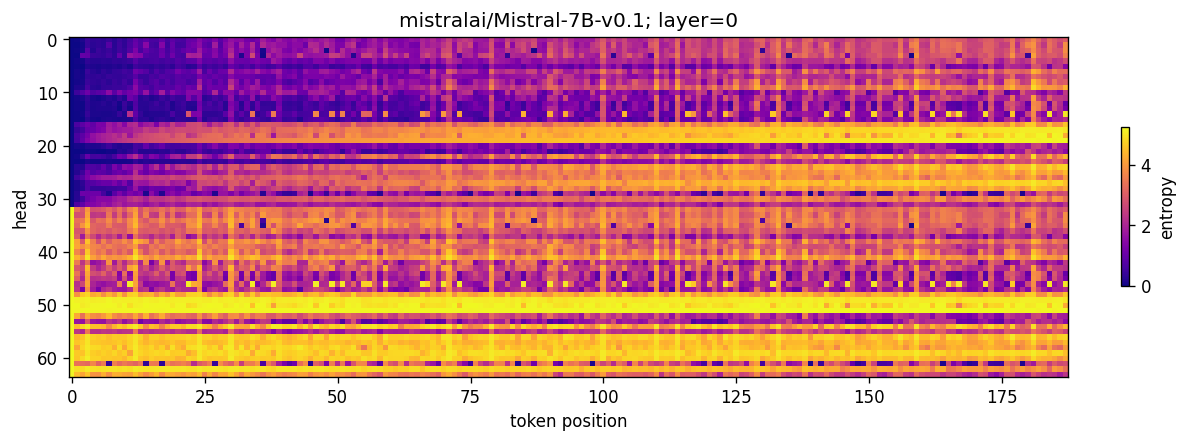

(64, 188)
max. value: 5.2355614
upper bound: 5.236441962829949


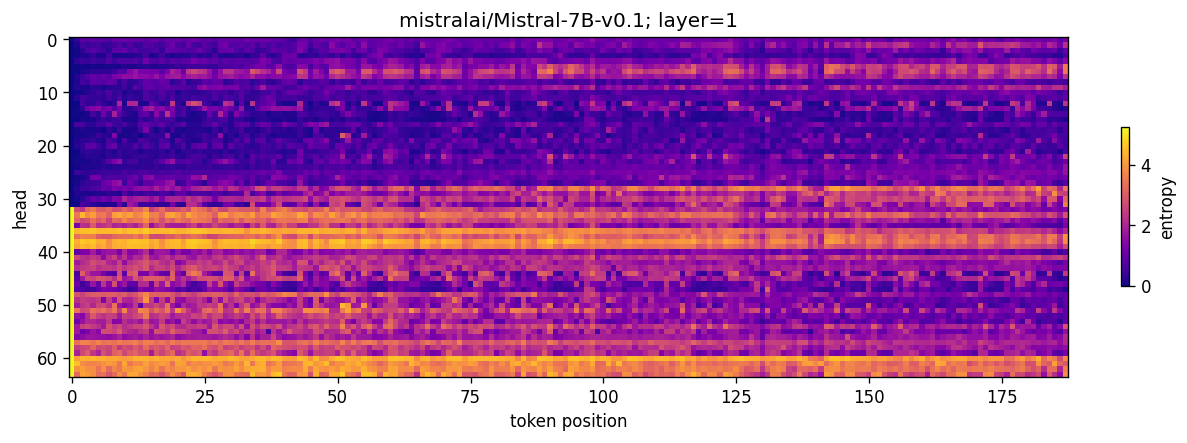

In [8]:
# plot entropy of each sequence position per head and layer

num_tokens = causal_attention_matrices.shape[-1]

for layer in range(num_layers)[:2]:
    H_c = compute_entropies_for_heads_at_layer(layer, causal_attention_matrices)
    H_b = compute_entropies_for_heads_at_layer(layer, bi_attention_matrices)
    
    # combine matrices
    H = np.concatenate((H_c, H_b), axis=0)
    
    print(H.shape)
    print("max. value:", np.max(H))
    print("upper bound:", np.log(num_tokens))

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(10, 5.5), dpi=120)

    im = axes.imshow(H, vmax=np.log(num_tokens), cmap="plasma")
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.0075, label="entropy")
    # axes.axhline(num_heads - 1, color="black", linewidth=2.0)

    axes.set_xlabel("token position")
    axes.set_ylabel("head")
    axes.set_title(f"{model_name_or_path}; layer={layer}")

    plt.tight_layout()
    plt.show()
    plt.close();


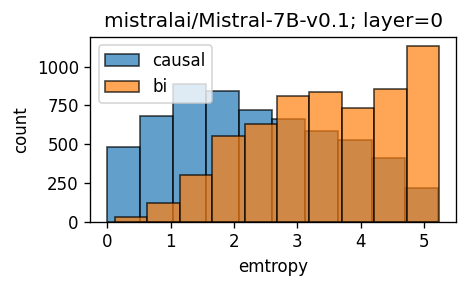

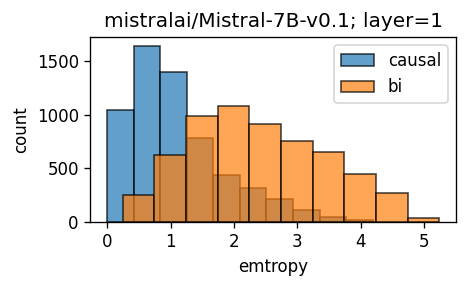

In [9]:
for layer in range(num_layers)[:2]:
    H_c = compute_entropies_for_heads_at_layer(layer, causal_attention_matrices)
    H_b = compute_entropies_for_heads_at_layer(layer, bi_attention_matrices)

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(4, 2.5), dpi=120)

    axes.hist(H_c.flatten(), edgecolor="black", alpha=0.7, label="causal")
    axes.hist(H_b.flatten(), edgecolor="black", alpha=0.7, label="bi")

    axes.set_xlabel("emtropy")
    axes.set_ylabel("count")
    
    axes.set_title(f"{model_name_or_path}; layer={layer}")
    axes.legend(loc="best")

    plt.tight_layout()
    plt.show()
    plt.close();

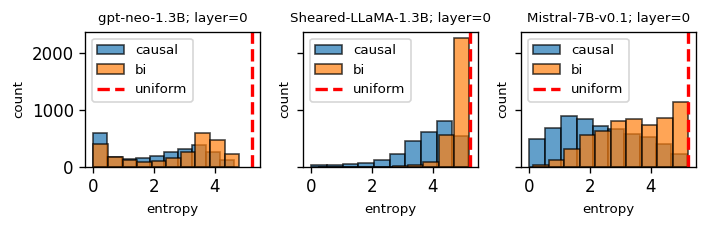

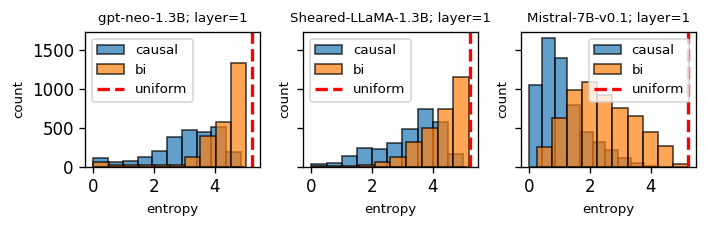

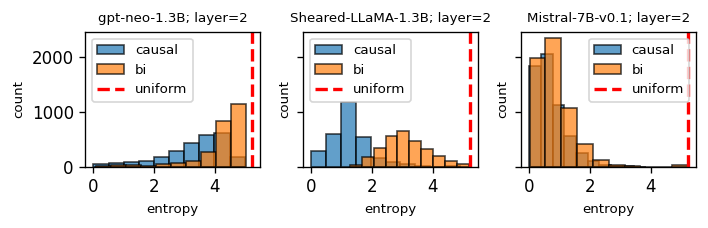

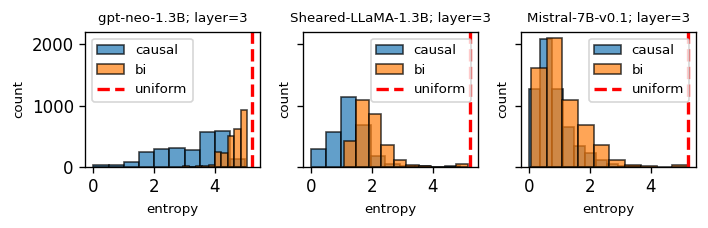

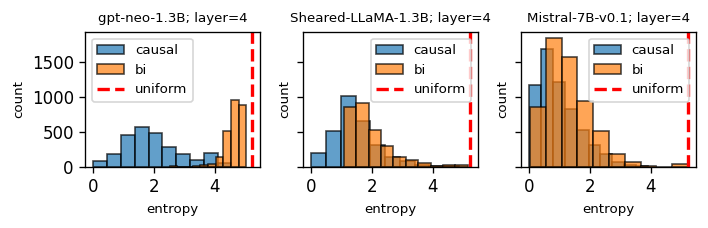

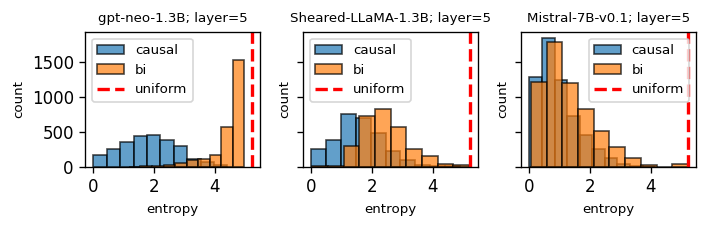

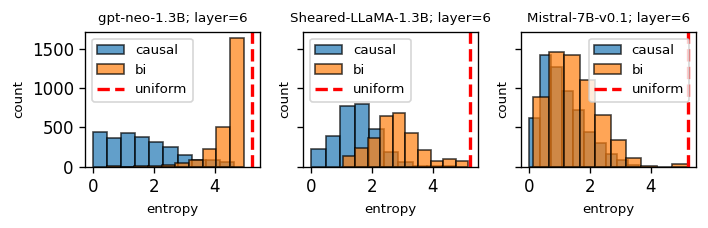

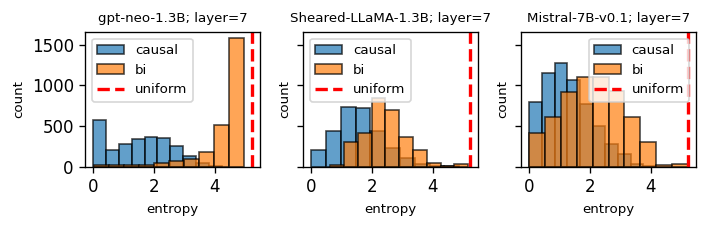

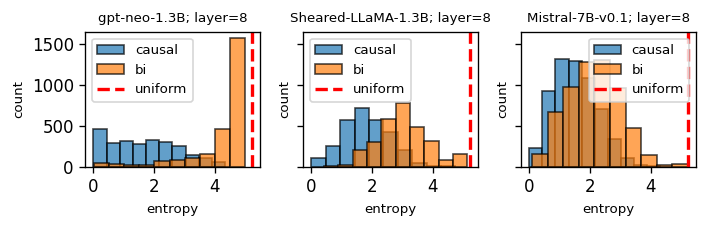

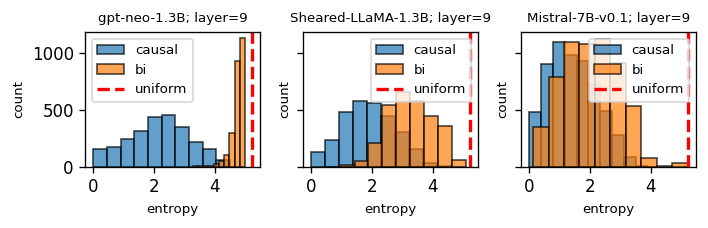

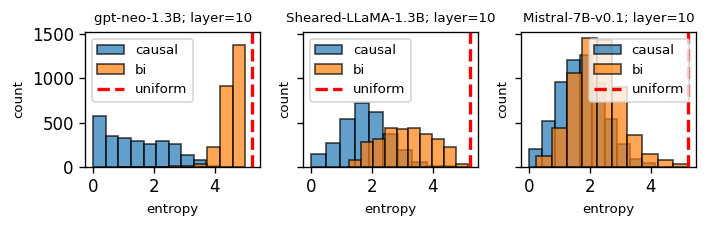

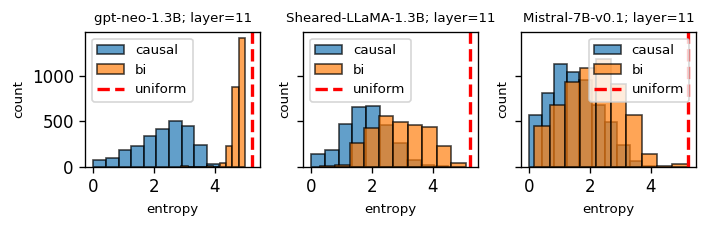

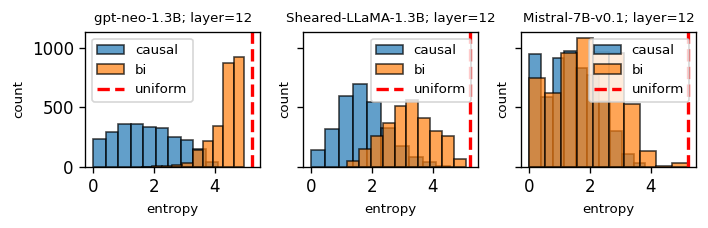

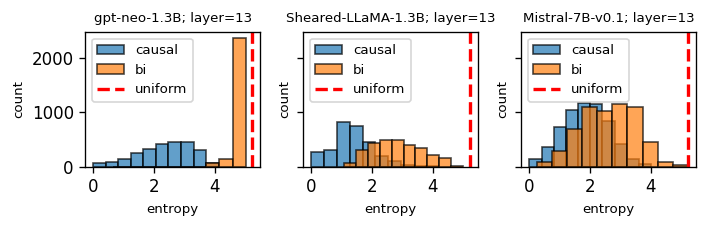

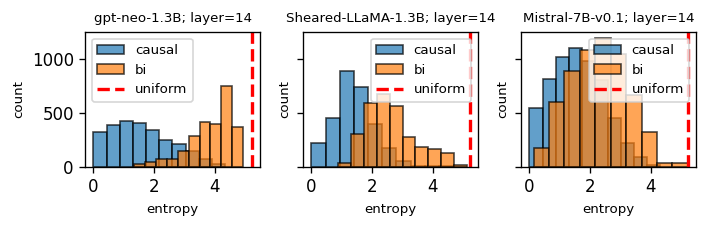

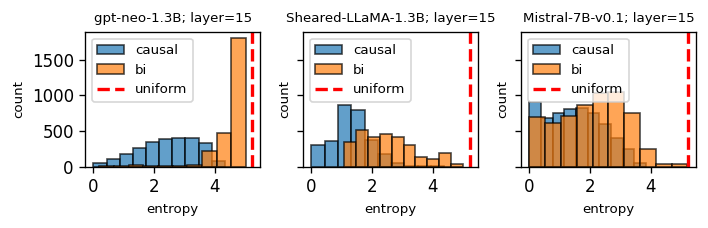

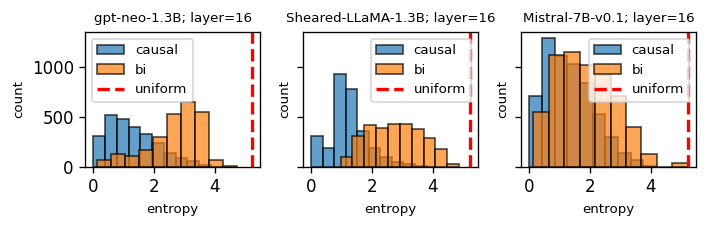

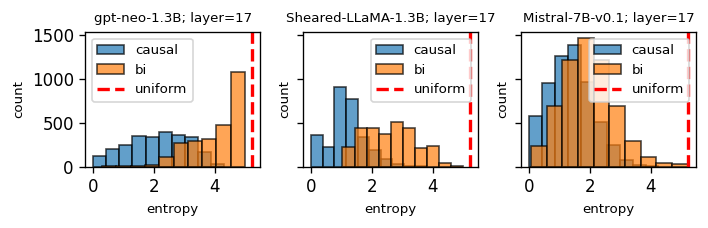

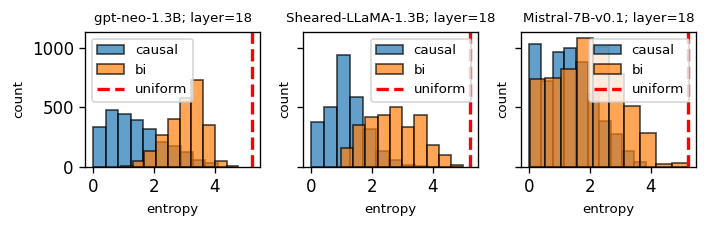

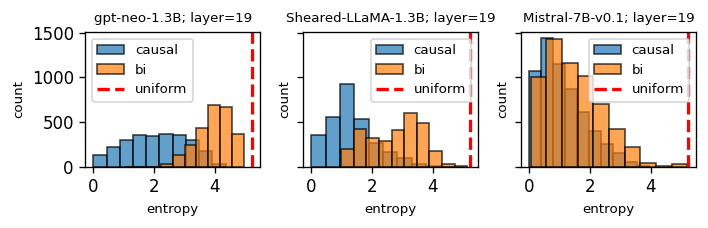

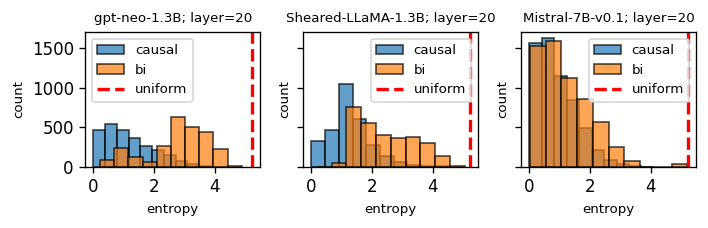

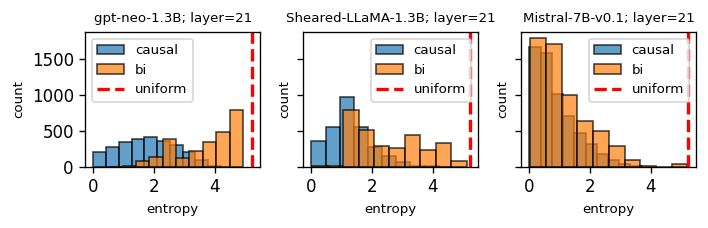

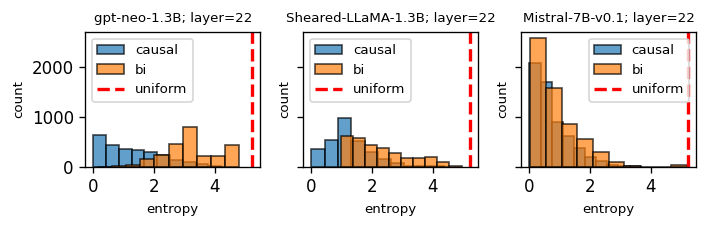

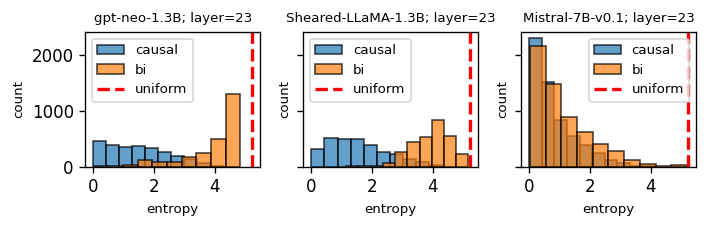

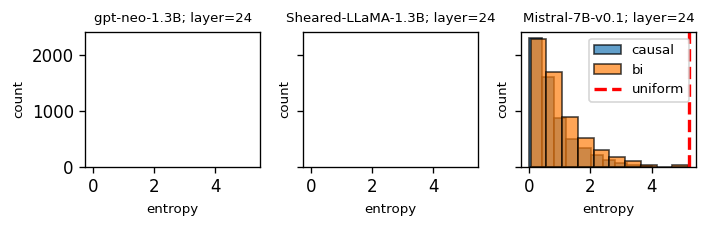

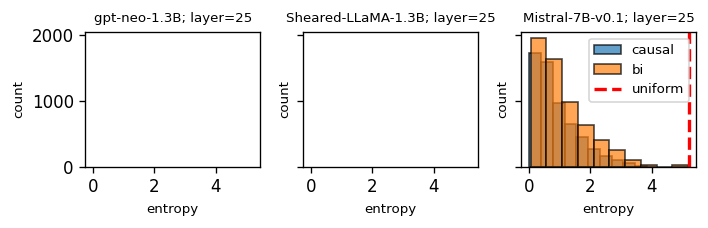

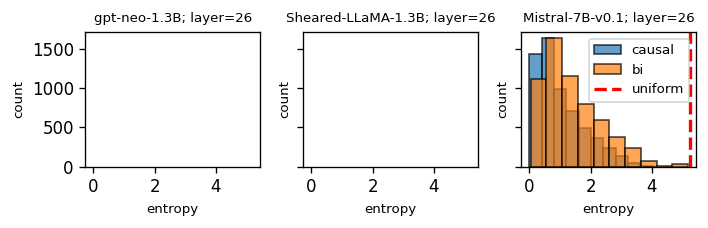

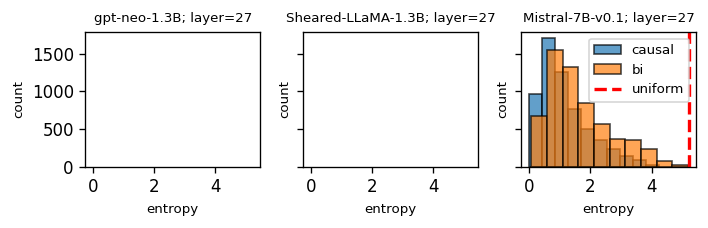

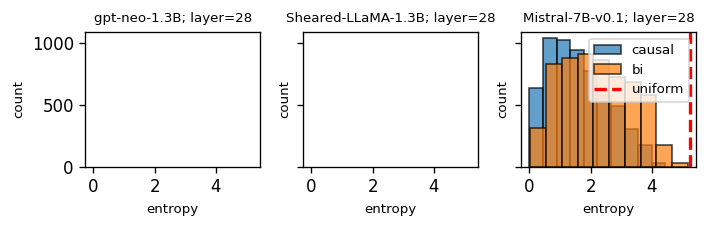

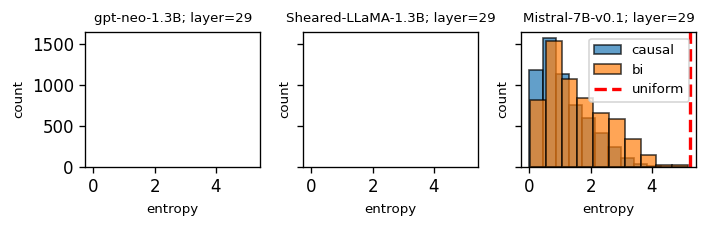

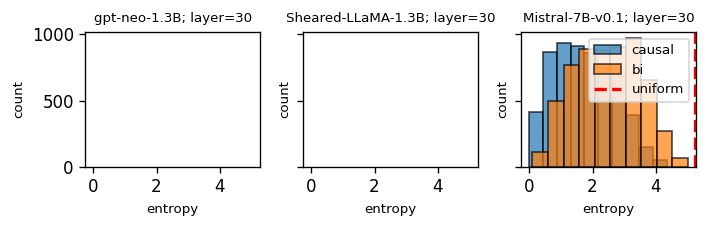

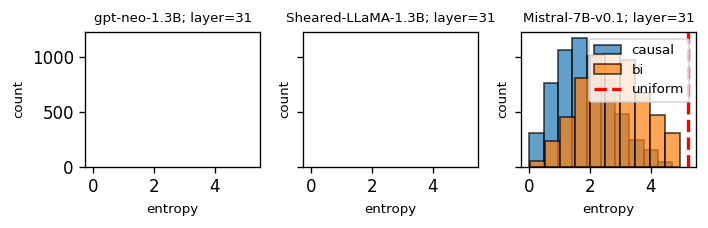

In [21]:
# entropy distributions for two models next to each other

MODELS = [
    ("EleutherAI/gpt-neo-1.3B", 24),
    ("princeton-nlp/Sheared-LLaMA-1.3B", 24),
    ("mistralai/Mistral-7B-v0.1", 32)
]

LAYERS = 32
for layer in range(LAYERS)[:]:

    fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharex=True, sharey=True, figsize=(len(MODELS) * 2.0, 2.0), dpi=120)

    for midx, (model_name_or_path, num_layers) in enumerate(MODELS):

        if layer >= num_layers:
            pass
        else:
            data_path = f"/projects/transformers/attention_data/{model_name_or_path.split('/')[-1]}"
            causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
            bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
            
            H_c = compute_entropies_for_heads_at_layer(layer, causal_attention_matrices)
            H_b = compute_entropies_for_heads_at_layer(layer, bi_attention_matrices)

            axes[midx].hist(H_c.flatten(), edgecolor="black", alpha=0.7, label="causal")
            axes[midx].hist(H_b.flatten(), edgecolor="black", alpha=0.7, label="bi")
            axes[midx].axvline(np.log(num_tokens), color="red", linestyle="dashed", linewidth=2.0, label="uniform")

            axes[midx].legend(loc="best", fontsize=8)

        axes[midx].set_xlabel("entropy", fontsize=8)
        axes[midx].set_ylabel("count", fontsize=8)
        axes[midx].set_title(f"{model_name_or_path.split('/')[-1]}; layer={layer}", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();